# LSTM with Keras

Based on a [Kaggle solution](https://www.kaggle.com/kredy10/simple-lstm-for-text-classification) by kredy10. See also tutorial by [Shivam Bansal](https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms) and on [Bag of Words](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words).

Dataset from [usableprivacy.org](https://usableprivacy.org/data/):

> [Identifying the Provision of Choices in Privacy Policy Text](https://usableprivacy.org/static/files/ksathyendra_acl_2017.pdf). Kanthashree Mysore Sathyendra, Shomir Wilson, Florian Schaub, Sebastian Zimmeck, and Norman Sadeh. Conference on Empirical Methods in Natural Language Processing (EMNLP), Copenhagen, Denmark, Sep 2017

To get this code to run, you need a data science environment. There are lots of guides around to get this set up, for example [this one](https://forum.schoolofdata.ch/t/interpreting-git-with-python/259) (schoolofdata.ch). If using Anaconda, install [keras](https://anaconda.org/conda-forge/keras) from conda-forge, as well as pandas, numpy, seaborn, matplotlib and sklearn, before continuing.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


Read in data from our sample file, and tweak it a bit (it's just a test) to create some lower case text content without funny characters.

In [2]:
df = pd.read_csv('OptOutTypeDataset.csv',delimiter=',',encoding='latin-1')
df.a2.replace("BR", "FI", inplace = True)
df.a2.replace("XX", "TH", inplace = True)
# Combine text columns
df['lowtext'] = df.fulltext.str.lower() # + " " + df.text.str.lower()
# Strip HTML tags
df['lowtext'] = df.lowtext.str.replace("<[^>]*>", "", regex=True)
# Remove all punctuation
df['lowtext'] = df.lowtext.str.replace('[^0-9a-zA-Z]+', ' ', regex=True)
# Show the first line
df.lowtext[0]

'we have engaged third party companies to process information about our users on our behalf to help us improve our sites and find new members these companies will combine our anonymized data about how you visit our websites with information that they have collected from outside our sites and provide it to us and only us so that we can optimize your experience on fool com across devices and based on your interests we will not provide the third party service providers with your name address email address or telephone number if you would like more information about the information we are receiving and your choices with respect to that data please visit the daa opt out program the evidon opt out program to learn how to opt out of having your information collected in browsers for ad serving purposes download the evidon ad control application available for ios and android to learn how to opt out of having your information collected in mobile apps and visit the network advertising initiative 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 15 columns):
id          102 non-null object
a1          91 non-null object
a2          102 non-null object
a3          101 non-null object
a4          102 non-null object
a5          90 non-null object
a6          102 non-null object
a7          101 non-null object
a8          102 non-null object
text        102 non-null object
button      102 non-null object
url         102 non-null object
fulltext    102 non-null object
html        102 non-null object
lowtext     102 non-null object
dtypes: object(15)
memory usage: 12.0+ KB


In [4]:
df.head()

,id,a1,a2,a3,a4,a5,a6,a7,a8,text,button,url,fulltext,html,lowtext
0,"1259,9,4,0",TH,TH,TH,TH,SH,AD,AD,AD,"visit the <a href=""http://www.aboutads.info/ch...",DAA opt-out program,http://www.aboutads.info/choices/,We have engaged third-party companies to proce...,1259_fool.com.html,we have engaged third party companies to proce...
1,"1259,9,4,1",FI,TH,BR,TH,SH,AD,AD,AD,"visit the <a href=""http://www.aboutads.info/ch...",Evidon opt-out program,http://choices.ghosteryenterprise.com/global-o...,We have engaged third-party companies to proce...,1259_fool.com.html,we have engaged third party companies to proce...
2,"1259,9,4,2",TH,TH,TH,TH,AD,AD,AD,AD,"visit the <a href=""http://www.aboutads.info/ch...",Network Advertising Initiative's opt out page,http://www.networkadvertising.org/choices/,We have engaged third-party companies to proce...,1259_fool.com.html,we have engaged third party companies to proce...
3,"133,10,2,0","FI, TH",FI,FI,FI,"AD, SH","CM, SH","AD, SH","AD, SH",If you prefer not to receive e-mail marketing ...,click here,https://subscription.timeinc.com/storefront/pr...,Privacy Options If you prefer not to receive...,133_fortune.com.html,privacy options if you prefer not to receive t...
4,"82,13,2,0",FI,FI,FI,FI,CM,CM,CM,CM,If you do not want to receive such email messa...,legal@sheknows.com,mailto:legal@sheknows.com?subject=No,"By providing Company your email address, you c...",82_drinksmixer.com.html,by providing company your email address you co...


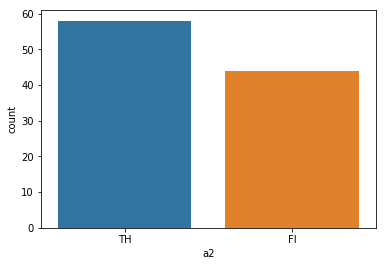

In [5]:
sns.countplot(df.a2)

In [6]:
X = df.lowtext
Y = df.a2
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [8]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [9]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [10]:
model.fit(sequences_matrix,Y_train,batch_size=16,epochs=20,
          validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 77 samples, validate on 9 samples
Epoch 1/20
77/77 [==============================] - 1s 16ms/step - loss: 0.6905 - acc: 0.5325 - val_loss: 0.6694 - val_acc: 0.6667
Epoch 2/20
77/77 [==============================] - 0s 5ms/step - loss: 0.6710 - acc: 0.6104 - val_loss: 0.6139 - val_acc: 0.8889
Epoch 3/20
77/77 [==============================] - 0s 5ms/step - loss: 0.5926 - acc: 0.7532 - val_loss: 0.5194 - val_acc: 0.8889
Epoch 4/20
77/77 [==============================] - 0s 5ms/step - loss: 0.5068 - acc: 0.8831 - val_loss: 0.3417 - val_acc: 1.0000
Epoch 5/20
77/77 [==============================] - 0s 5ms/step - loss: 0.5447 - acc: 0.8831 - val_loss: 0.3316 - val_acc: 0.8889
Epoch 6/20
77/77 [==============================] - 0s 6ms/step - loss: 0.2810 - acc: 0.9091 - val_loss: 0.1651 - val_acc: 1.0000
Epoch 7/20
77/77 [==============================] - 0s 5ms/step - loss: 0.3967 - acc: 0.8961 - val_loss: 0.2276 - val_acc: 1.0000


In [11]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)

16/16 [==============================] - 0s 1ms/step


In [12]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.381
  Accuracy: 0.875
